<a href="https://colab.research.google.com/github/fboldt/aulas-am-bsi/blob/main/aula21b_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[-0.69177074  0.46810595] -0.6704441220699868


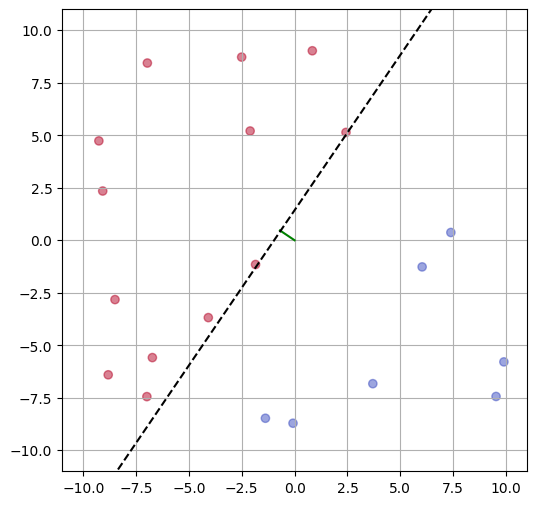

In [262]:
import numpy as np
import matplotlib.pyplot as plt

def generate_linear_separable_dataset(n_samples, weights, bias):
    n_features = len(weights)
    X = np.random.rand(n_samples, n_features)*20-10
    y = np.sign(np.dot(X, weights) + bias)
    return X, y

def plot_dataset(X, y, xlim=(-11, 11), ylim=(-11, 11)):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, marker='o', alpha=0.5, cmap="coolwarm")
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.grid(True)

def plot_vector(weights):
    xs = [0, weights[0]]
    ys = [0, weights[1]]
    plt.plot(xs, ys, 'g-')

def plot_hyperplane(weights, bias):
    xs = np.array([-11, 11])
    ys = -(weights[0]*xs + bias)/weights[1]
    plt.plot(xs, ys, 'k--')

weights = np.random.rand(2)*2-1
bias = np.random.rand()*6-3
print(weights, bias)

X, y = generate_linear_separable_dataset(20, weights, bias)
plot_dataset(X, y)
plot_vector(weights)
plot_hyperplane(weights, bias)
plt.show()

In [263]:
from abc import ABC, abstractmethod

class CostFunction(ABC):
    @abstractmethod
    def getCost(self, y, ypred):
        pass
    @abstractmethod
    def getGradient(self, X):
        pass

class WidrowHoff(CostFunction):
    def getCost(self, y, ypred):
        self.error = y - ypred
        return 0.5 * np.sum(self.error**2)
    def getGradient(self, X):
        return -X.T @ self.error

In [264]:
from abc import ABC, abstractmethod

class Algorithm(ABC):
    @abstractmethod
    def getW(self, X, y):
        pass


class GradientDescent(Algorithm):
    def __init__(self, max_iter, learning_rate,
                 cost_function=WidrowHoff(),
                 regularization=0):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.cost_function = cost_function
        self.regularization = regularization

    def getW(self, X, y):
        w = np.random.rand(X.shape[1])
        for _ in range(self.max_iter):
            ypred = X @ w
            cost = self.cost_function.getCost(y, ypred)
            w *= 1 - self.learning_rate * self.regularization
            w -= self.learning_rate * self.cost_function.getGradient(X)
            if cost == 0:
                break
        return w

[-0.10870622  0.06564731] 0.21608382183850394
1.0


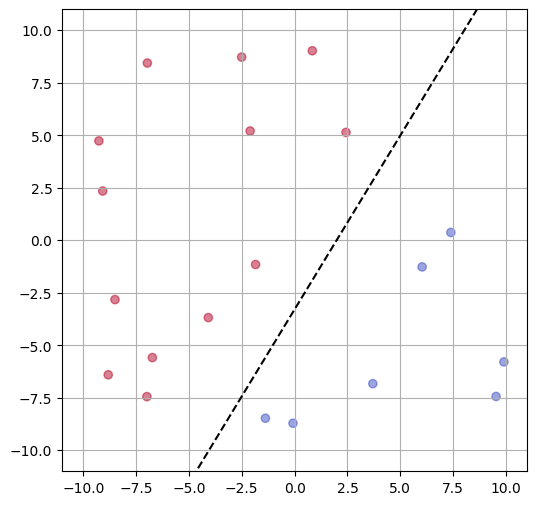

In [265]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

def include_bias(X):
  ones = np.ones(shape=(X.shape[0],1))
  return np.hstack((ones, X))

class NeuralNetwork(BaseEstimator, ClassifierMixin):
  def __init__(self, algorithm):
    self.algorithm = algorithm

  def fit(self, X, y):
    X = include_bias(X)
    self.w = self.algorithm.getW(X, y)
    self.coefs_ = self.w[1:]
    self.intercept_ = self.w[0]
    return self

  def predict(self, X):
    X = include_bias(X)
    ypred = (X @ self.w)
    return np.sign(ypred)


model = NeuralNetwork(algorithm=GradientDescent(1000, 0.001))
model.fit(X, y)
print(model.coefs_, model.intercept_)
ypred = model.predict(X)
print(accuracy_score(y, ypred))
plot_dataset(X, y)
plot_hyperplane(model.coefs_, model.intercept_)
plt.show()

[-0.40891577  0.41407151] 0.40231470000222314
1.0


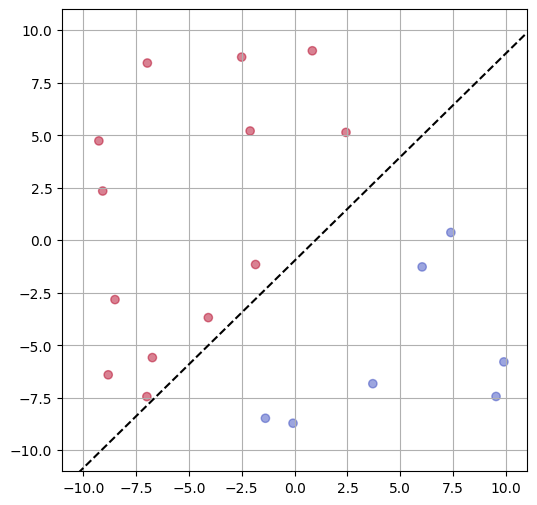

In [266]:
class SmoothedSurrogate(CostFunction):
    def getCost(self, y, ypred):
        self.error = y - np.sign(ypred)
        return np.sum(np.maximum(np.zeros(y.shape), -y * ypred))
    def getGradient(self, X):
        return -X.T @ self.error

model = NeuralNetwork(algorithm=GradientDescent(1000, 0.001, SmoothedSurrogate()))
model.fit(X, y)
print(model.coefs_, model.intercept_)
ypred = model.predict(X)
print(accuracy_score(y, ypred))
plot_dataset(X, y)
plot_hyperplane(model.coefs_, model.intercept_)
plt.show()

[-0.55986731  0.38098876] 0.4058277279635549
1.0


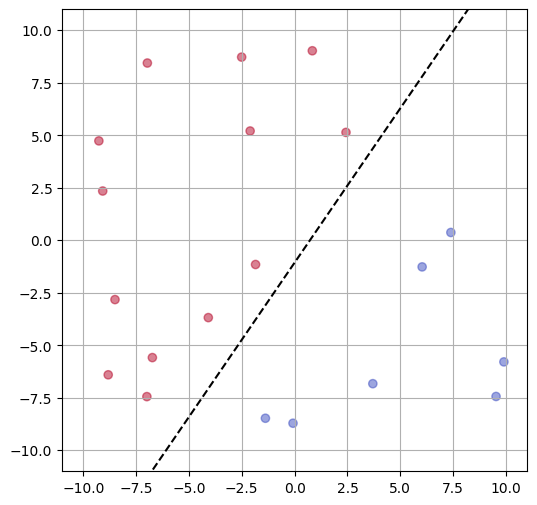

In [267]:
class HingeLoss(CostFunction):
    def getCost(self, y, ypred):
        self.y = y
        self.ypred = ypred
        self.error = y - np.sign(ypred)
        return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
    def getGradient(self, X):
        marginal_errors = (self.y * self.ypred) < 1
        marginal_ys = np.copy(self.y)
        marginal_ys[~marginal_errors] = 0
        return -X.T @ marginal_ys

model = NeuralNetwork(algorithm=GradientDescent(1000, 0.001, HingeLoss()))
model.fit(X, y)
print(model.coefs_, model.intercept_)
ypred = model.predict(X)
print(accuracy_score(y, ypred))
plot_dataset(X, y)
plot_hyperplane(model.coefs_, model.intercept_)
plt.show()

[-76.24186477  69.89632014] -12.202249775877075
1.0


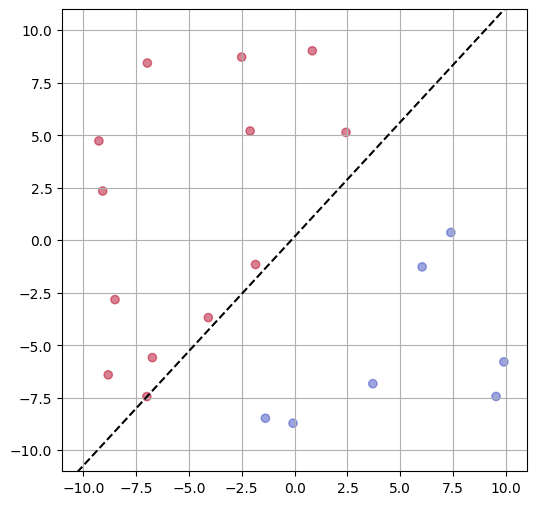

In [268]:
from scipy.special import expit

class LogLikehood(CostFunction):
    def getCost(self, y, ypred):
        self.error = y - expit(ypred)
        return np.sum(np.log(1 + np.exp(-y * ypred)))
    def getGradient(self, X):
        return -X.T @ self.error

model = NeuralNetwork(algorithm=GradientDescent(2000, 0.001, LogLikehood()))
model.fit(X, y)
print(model.coefs_, model.intercept_)
ypred = model.predict(X)
print(accuracy_score(y, ypred))
plot_dataset(X, y)
plot_hyperplane(model.coefs_, model.intercept_)
plt.show()

In [269]:
def plot_dataset(X, y, xlim=(-11, 11), ylim=(-11, 11)):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, marker='o', alpha=0.2)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.grid(True)

[-0.10870623  0.06564731] 0.21608381453301476
WidrowHoff 0.833


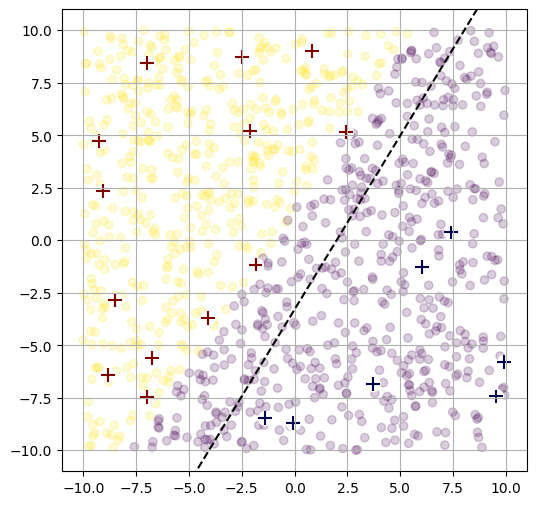

[-0.08108546  0.10094102] 0.23853320056101768
SmoothedSurrogate 0.81


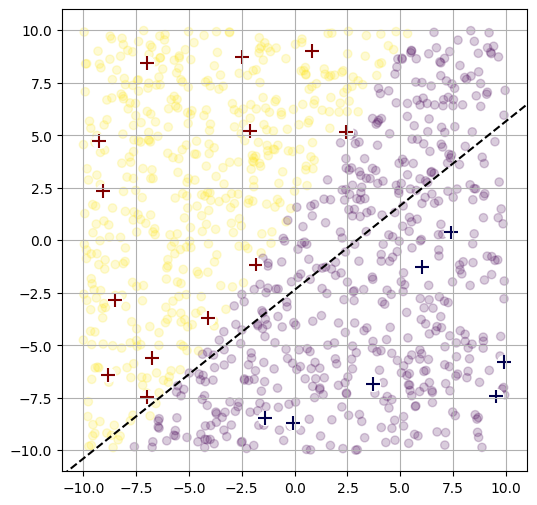

[-0.53741863  0.36867498] 0.4342960119956638
HingeLoss 0.906


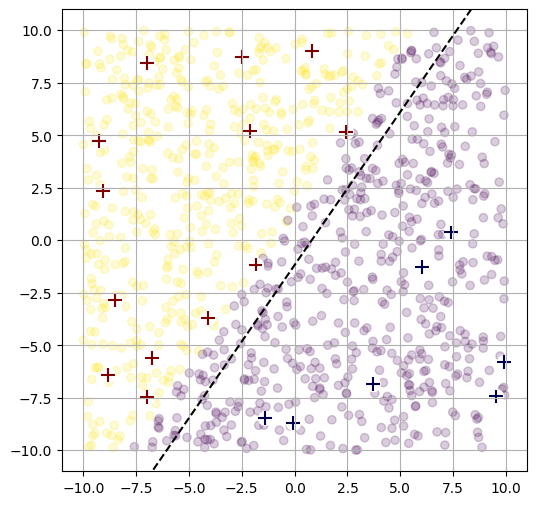

[-381.62149631  349.40744029] -65.52066572163696
LogLikehood 0.928


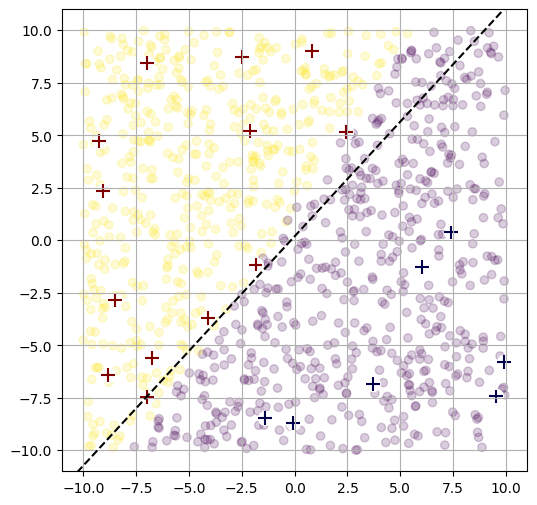

In [270]:
cost_functions = [WidrowHoff, SmoothedSurrogate, HingeLoss, LogLikehood]

X_test, y_test = generate_linear_separable_dataset(1000, weights, bias)

for cost in cost_functions:
  model = NeuralNetwork(algorithm=GradientDescent(10000, 0.001, cost()))
  model.fit(X, y)
  print(model.coefs_, model.intercept_)
  ypred = model.predict(X_test)
  print(cost.__name__, accuracy_score(y_test, ypred))
  plot_dataset(X_test, y_test)
  plt.scatter(X[:, 0], X[:, 1], marker='o', c='white', s=100)
  plt.scatter(X[:, 0], X[:, 1], marker='+', c=y, cmap='seismic', s=100)
  plot_hyperplane(model.coefs_, model.intercept_)
  plt.show()


[-0.10357609  0.05383447] 0.03510333704652144
WidrowHoff 0.934


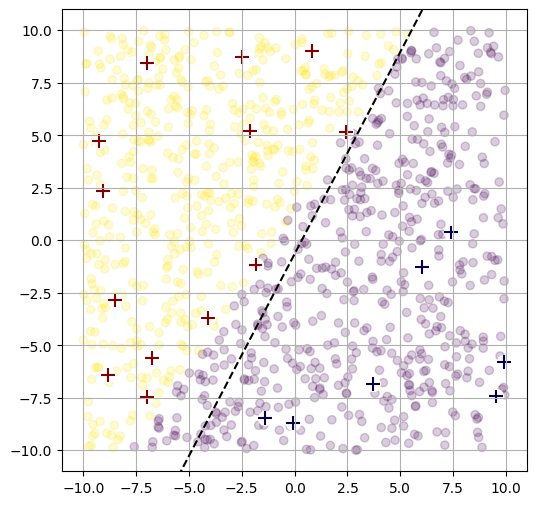

[-0.12595572  0.14102978] 0.3431663705728764
SmoothedSurrogate 0.823


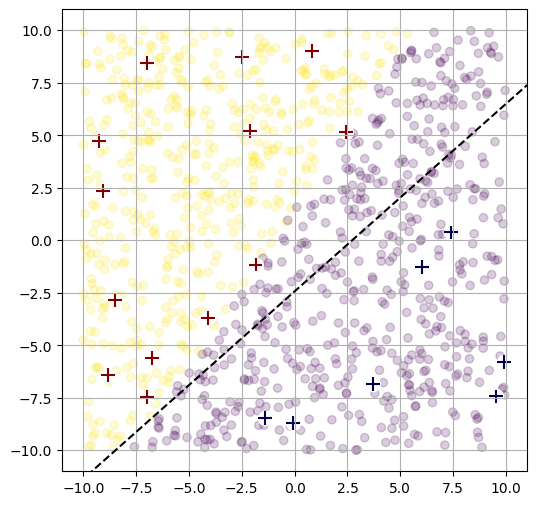

[-0.19167164  0.10565994] 0.045008343136128656
HingeLoss 0.936


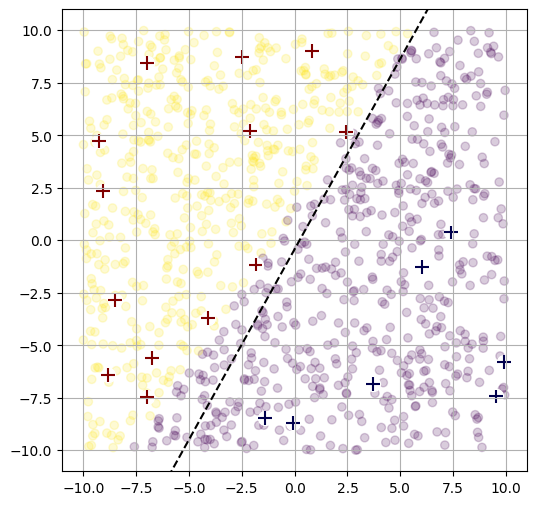

[-0.43970949  0.34684252] -0.05041611807819519
LogLikehood 0.957


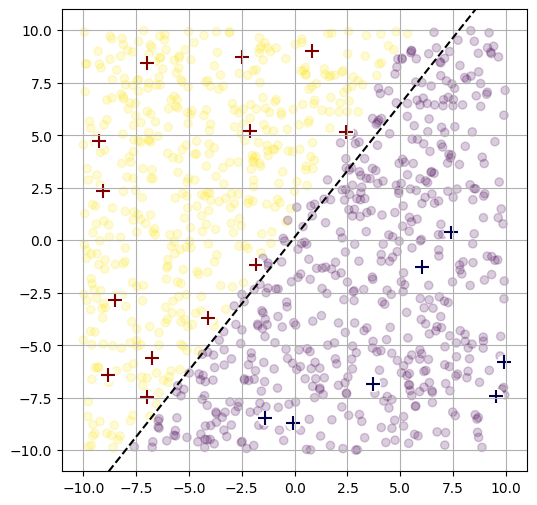

In [277]:
for cost in cost_functions:
  model = NeuralNetwork(algorithm=GradientDescent(10000, 0.001, cost(), 100))
  model.fit(X, y)
  print(model.coefs_, model.intercept_)
  ypred = model.predict(X_test)
  print(cost.__name__, accuracy_score(y_test, ypred))
  plot_dataset(X_test, y_test)
  plt.scatter(X[:, 0], X[:, 1], marker='o', c='white', s=100)
  plt.scatter(X[:, 0], X[:, 1], marker='+', c=y, cmap='seismic', s=100)
  plot_hyperplane(model.coefs_, model.intercept_)
  plt.show()